In [41]:
# Datos
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
class PnlQuanfury:
    __path = None
    df = None

    def __init__(self, path):
        self.__path = path
        self.df = pd.read_excel(self.__path)

        self.df["Average Price"] = np.nan
        self.df["Cantidad Invertida"] = np.nan
        self.df["Quantity restante"] = np.nan

        self.df["Group"] = (self.df["Total Position PnL"].notna().cumsum().shift().fillna(0)).astype(int)

    def delete_columns_empty(self):
        self.df = self.df.dropna(thresh=2)

    def clean_all_column(self):
        symbols = ['₮', '$', '€', ',', ' ']
        fer = [r'[a-zA-Z]']
        self.clean_column("Quantity", fer, reg=True)
        self.clean_column("Quantity", symbols)
        self.clean_column("Price", symbols)
        self.clean_column("Value", symbols)
        self.clean_column("Total Position PnL", symbols)

    def convert_float_all_column(self):
        self.__convert_float_column("Quantity")
        self.__convert_float_column("Price")
        self.__convert_float_column("Value")
        self.__convert_float_column("Total Position PnL")

    def __convert_float_column(self, column):
        self.df[column] = self.df[column].astype(float)

    def clean(self):
        self.delete_columns_empty()
        self.clean_all_column()
        self.convert_float_all_column()
        self.convert_date()

    def convert_date(self):
        self.df["Date"] = pd.to_datetime(self.df["Date"], format='%d.%m.%Y %I:%M %p %Z')

    def clean_column(self, column, list_simbol, reg=False):
        for simbol in list_simbol:
            self.df[column] = self.df[column].str.replace(simbol, '', regex=reg)

    def pnl_by_month(self, year):
        df_year = self.df[self.df["Date"].dt.year == year]
        df_year = df_year.groupby(df_year["Date"].dt.month)["Total Position PnL"].sum()

        # Si falta un mes lo rellenamos con 0
        for i in range(1, 13):
            if i not in df_year.index:
                df_year[i] = 0

        return df_year
    
    def calculate_signed_quantity(self):
        # Create 'Signed Quantity' column
        self.df['Signed Quantity'] = self.df.apply(lambda row: -row['Quantity'] if row['Action'] == 'Sold' else row['Quantity'], axis=1)

        # Group by 'Group' and calculate the cumulative sum of 'Signed Quantity'
        self.df['Quantity restante'] = self.df.groupby('Group')['Signed Quantity'].cumsum()

        # Drop the 'Signed Quantity' column
        self.df = self.df.drop(columns=['Signed Quantity'])

    def calculate_average_price(self):
        # Function to calculate the cumulative average price
        def calculate(row):
            # Filter previous rows of the same group that are not the last row
            previous_rows = self.df[(self.df['Group'] == row['Group']) & (self.df.index < row.name)]
            
            # If there are no previous rows, return NaN
            if previous_rows.empty:
                return np.nan
            
            # Create a 'Signed Quantity' column where the quantities of sold shares are negative
            previous_rows['Signed Quantity'] = previous_rows.apply(lambda row: -row['Quantity'] if row['Action'] == 'Sold' else row['Quantity'], axis=1)
            
            # Calculate the average price
            average_price = (previous_rows['Signed Quantity'] * previous_rows['Price']).sum() / previous_rows['Signed Quantity'].sum()
            
            return average_price

        # Apply the function to each row
        self.df['Average Price'] = self.df.apply(calculate, axis=1)
        self.df["Average Price"] = self.df["Average Price"].shift(-1)

    def calculate_inverted_quantity(self):
        # Crear una nueva columna 'Signed Value' donde los valores de las acciones vendidas son negativos
        self.df['Signed Value'] = self.df.apply(lambda row: -row['Value'] if row['Action'] == 'Sold' else row['Value'], axis=1)

        # Calcular la cantidad invertida para cada grupo utilizando transform y cumsum
        self.df['Cantidad Invertida'] = self.df.groupby('Group')['Signed Value'].transform(pd.Series.cumsum)

        # Eliminar la columna 'Signed Value'
        self.df = self.df.drop(columns=['Signed Value'])

In [43]:
fer = PnlQuanfury('./quantfury/fer3.xls')
fer.clean()

In [44]:
fer.calculate_signed_quantity()
fer.calculate_average_price()
fer.calculate_inverted_quantity()

In [45]:
df = fer.df
df.head()

,Name,Action,Quantity,Price,Value,Date,Total Position PnL,Average Price,Cantidad Invertida,Quantity restante,Group
0,INTC,Bought,2.0,36.86,73.72,2023-06-20 13:34:00+00:00,NaN,36.860,73.72,2.0,0
1,INTC,Sold,2.0,34.53,73.72,2023-06-21 13:48:00+00:00,-4.66,NaN,0.00,0.0,0
3,INTC,Bought,1.0,34.62,34.62,2023-06-14 17:38:00+00:00,NaN,34.620,34.62,1.0,1
4,INTC,Bought,1.0,35.62,35.62,2023-06-15 13:33:00+00:00,NaN,35.120,70.24,2.0,1
5,INTC,Bought,6.0,35.70,214.20,2023-06-15 14:02:00+00:00,NaN,35.555,284.44,8.0,1


# 01

In [5]:
def plot_pnl_by_month(serie, year):
    # Set the style of the plot
    plt.figure(figsize=(12, 6))
    
    # Add title with date
    plt.title('Total Position PnL by month in ' + str(year))
    
    # Create a list of colors: 'g' for positive values, 'r' for negative values
    colors = ['g' if value >= 0 else 'r' for value in serie.values]
    
    # Create the bar plot
    sns.barplot(x=serie.index, y=serie.values, palette=colors, legend=False)
    
    # Add names of the months on the x-axis
    plt.xticks(np.arange(12), ('Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio',
                               'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'))
    plt.xticks(rotation=45)
    
    # Add the value of each bar
    for index, row in enumerate(serie):
        plt.text(index, row, str(round(row, 2)), ha="center", va="bottom")
    
    # Add labels for the axes
    plt.xlabel('Month')
    plt.ylabel('PnL')
    
    # The sum of all bars in a legend
    total_pnl = serie.sum()
    average_pnl = serie.mean()

    # Total PnL
    plt.annotate(f'Total PnL: {round(total_pnl, 2)}', xy=(0, 0.5), xytext=(0.085, 0.89), xycoords='axes fraction',fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round', fc='w'))

    # Average PnL
    plt.annotate(f'Average PnL: {round(average_pnl, 2)}', xy=(0, 0.5), xytext=(0.1, 0.96), xycoords='axes fraction',fontsize=12, ha='center', va='center', bbox=dict(boxstyle='round', fc='w'))
    
    plt.grid(True)
    plt.show()


C:\Users\lufer\AppData\Local\Temp\ipykernel_28392\3465231931.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=serie.index, y=serie.values, palette=colors, legend=False)


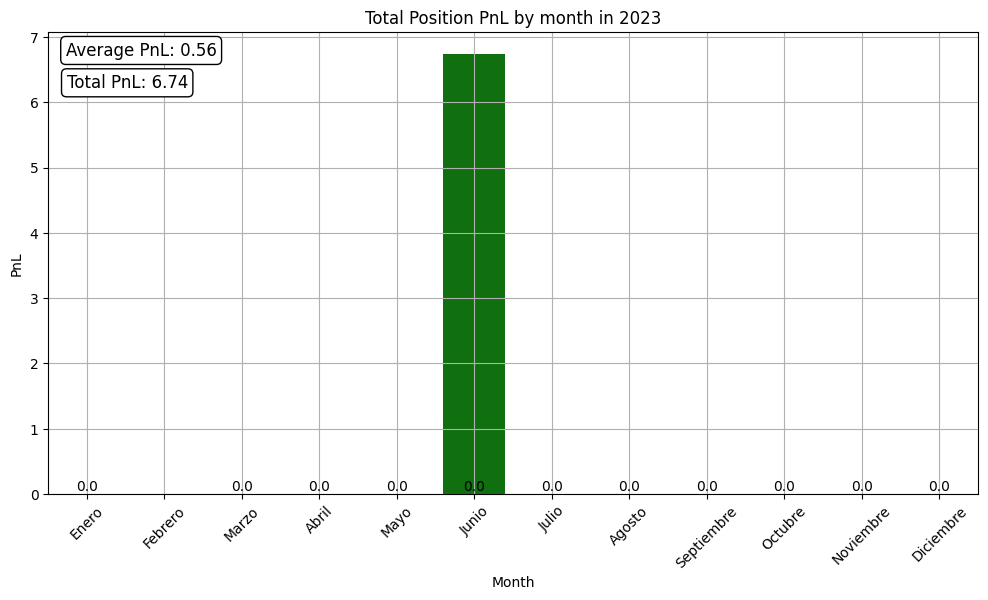

In [6]:
year = 2023
plot_pnl_by_month(fer.pnl_by_month(year), year)

In [7]:
df.head(10)

,Name,Action,Quantity,Price,Value,Date,Total Position PnL
0,INTC,Bought,2.0,36.86,73.72,2023-06-20 13:34:00+00:00,NaN
1,INTC,Sold,2.0,34.53,73.72,2023-06-21 13:48:00+00:00,-4.66
3,INTC,Bought,1.0,34.62,34.62,2023-06-14 17:38:00+00:00,NaN
4,INTC,Bought,1.0,35.62,35.62,2023-06-15 13:33:00+00:00,NaN
5,INTC,Bought,6.0,35.70,214.20,2023-06-15 14:02:00+00:00,NaN
6,INTC,Sold,8.0,35.64,284.44,2023-06-15 17:23:00+00:00,0.68
8,INTC,Bought,1.0,32.77,32.77,2023-04-05 17:47:00+00:00,NaN
9,INTC,Bought,1.0,31.80,31.80,2023-04-13 13:30:00+00:00,NaN
10,INTC,Bought,1.0,32.28,32.28,2023-04-18 13:34:00+00:00,NaN
11,INTC,Bought,4.0,32.28,129.12,2023-04-18 13:34:00+00:00,NaN


In [8]:
year = 2023
b = df[df["Date"].dt.year == year]
        
a = b.groupby(df["Name"])["Total Position PnL"].sum().sort_values(ascending=False)

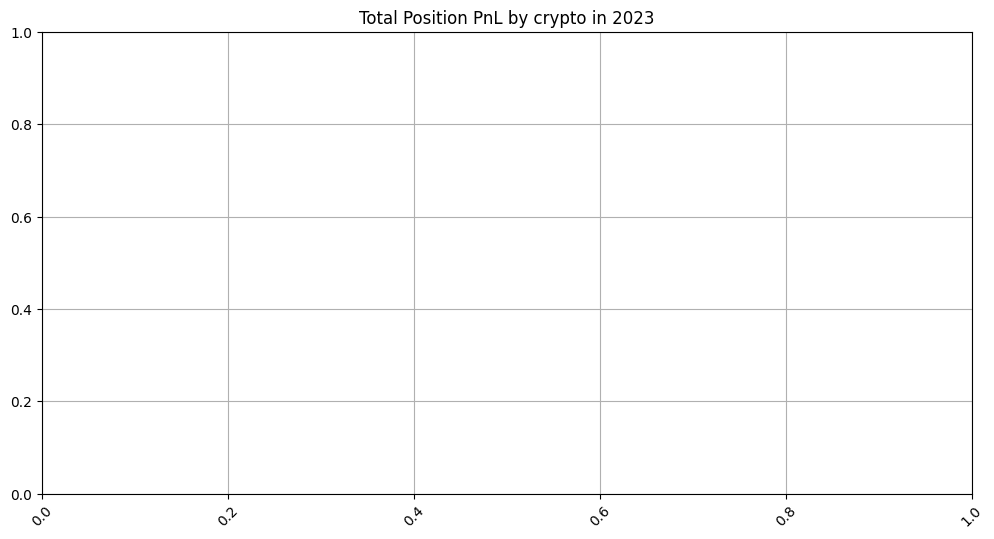

In [9]:
# Filtramos por criptos, si la columna "Name" contiene "/" es una cripto
df_cripto = df[df["Name"].str.contains('/')]
year = 2023
df_cripto = df_cripto[df_cripto["Date"].dt.year == year]
df_cripto = df_cripto.groupby(df_cripto["Name"])["Total Position PnL"].sum().sort_values(ascending=False)

# Grafica de barras
plt.figure(figsize=(12, 6))
plt.title('Total Position PnL by crypto in ' + str(year))
sns.barplot(x=df_cripto.index, y=df_cripto.values, hue=df_cripto.index, palette='deep', legend=False)
plt.xticks(rotation=45)

# Add the value of each bar
for index, row in enumerate(df_cripto):
    plt.text(index, row, str(round(row, 2)), ha="center", va="bottom")

plt.grid(True)
plt.show()


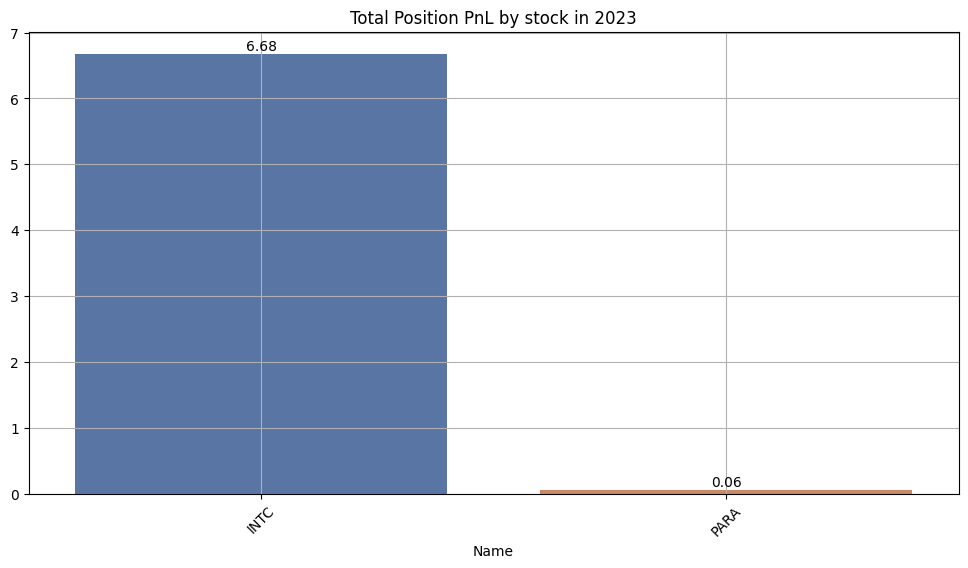

In [10]:
# Acciones
df_acciones = df[df["Name"].str.contains('/') == False]
year = 2023
df_acciones = df_acciones[df_acciones["Date"].dt.year == year]
df_acciones = df_acciones.groupby(df_acciones["Name"])["Total Position PnL"].sum().sort_values(ascending=False)
#df_acciones = df_acciones.head(-10)
# Grafica de barras
plt.figure(figsize=(12, 6))
plt.title('Total Position PnL by stock in ' + str(year))
sns.barplot(x=df_acciones.index, y=df_acciones.values, hue=df_acciones.index, palette='deep', legend=False)
plt.xticks(rotation=45)

# Add the value of each bar
for index, row in enumerate(df_acciones):
    plt.text(index, row, str(round(row, 2)), ha="center", va="bottom")

plt.grid(True)
plt.show()

# fer

In [11]:
df

,Name,Action,Quantity,Price,Value,Date,Total Position PnL
0,INTC,Bought,2.0,36.86,73.72,2023-06-20 13:34:00+00:00,NaN
1,INTC,Sold,2.0,34.53,73.72,2023-06-21 13:48:00+00:00,-4.66
3,INTC,Bought,1.0,34.62,34.62,2023-06-14 17:38:00+00:00,NaN
4,INTC,Bought,1.0,35.62,35.62,2023-06-15 13:33:00+00:00,NaN
5,INTC,Bought,6.0,35.70,214.20,2023-06-15 14:02:00+00:00,NaN
6,INTC,Sold,8.0,35.64,284.44,2023-06-15 17:23:00+00:00,0.68
8,INTC,Bought,1.0,32.77,32.77,2023-04-05 17:47:00+00:00,NaN
9,INTC,Bought,1.0,31.80,31.80,2023-04-13 13:30:00+00:00,NaN
10,INTC,Bought,1.0,32.28,32.28,2023-04-18 13:34:00+00:00,NaN
11,INTC,Bought,4.0,32.28,129.12,2023-04-18 13:34:00+00:00,NaN


In [12]:
# Creamos una columna vacia para precio promedio
df["Average Price"] = np.nan
df["Cantidad Invertida"] = np.nan
df["Quantity restante"] = np.nan

In [13]:
df["Group"] = (df["Total Position PnL"].notna().cumsum().shift().fillna(0)).astype(int)

In [14]:
df['Signed Quantity'] = df.apply(lambda row: -row['Quantity'] if row['Action'] == 'Sold' else row['Quantity'], axis=1)

# Agrupar por 'Group' y calcular la suma acumulativa de 'Signed Quantity'
df['Quantity restante'] = df.groupby('Group')['Signed Quantity'].cumsum()

# Eliminar la columna 'Signed Quantity'
df = df.drop(columns=['Signed Quantity'])

In [15]:
# Función para calcular el precio promedio acumulativo
def calculate_average_price(row, df):
    # Filtrar las filas anteriores del mismo grupo y que no sean la última fila
    previous_rows = df[(df['Group'] == row['Group']) & (df.index < row.name)]
    
    # Si no hay filas anteriores, retornar NaN
    if previous_rows.empty:
        return np.nan
    
    # Crear una columna 'Signed Quantity' donde las cantidades de las acciones vendidas son negativas
    previous_rows['Signed Quantity'] = previous_rows.apply(lambda row: -row['Quantity'] if row['Action'] == 'Sold' else row['Quantity'], axis=1)
    
    # Calcular el precio promedio
    average_price = (previous_rows['Signed Quantity'] * previous_rows['Price']).sum() / previous_rows['Signed Quantity'].sum()
    
    return average_price

# Aplicar la función a cada fila
df['Average Price'] = df.apply(lambda row: calculate_average_price(row, df), axis=1)
df["Average Price"] = df["Average Price"].shift(-1)

In [16]:
# Crear una nueva columna 'Signed Value' donde los valores de las acciones vendidas son negativos
df['Signed Value'] = df.apply(lambda row: -row['Value'] if row['Action'] == 'Sold' else row['Value'], axis=1)

# Calcular la cantidad invertida para cada grupo utilizando transform y cumsum
df['Cantidad Invertida'] = df.groupby('Group')['Signed Value'].transform(pd.Series.cumsum)

# Eliminar la columna 'Signed Value'
df = df.drop(columns=['Signed Value'])